# DRAFT 01

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# Load dataset
df = pd.read_csv('/content/AllData.csv')

# Drop unnecessary columns
df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data (z-score)
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Define windowing parameters
window_size = 128
stride = window_size // 2  # 50% overlap

# Create sliding windows
X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)

X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Prepare for DL
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Build Multi-Head Temporal Attention model
inputs = layers.Input(shape=(window_size, 6))
acc = layers.Lambda(lambda x: x[:, :, :3])(inputs)
gyro = layers.Lambda(lambda x: x[:, :, 3:])(inputs)

acc_emb = layers.Dense(32, activation='relu')(acc)
gyro_emb = layers.Dense(32, activation='relu')(gyro)

attn_acc = layers.MultiHeadAttention(num_heads=2, key_dim=32)(acc_emb, acc_emb)
attn_gyro = layers.MultiHeadAttention(num_heads=2, key_dim=32)(gyro_emb, gyro_emb)

concat = layers.Concatenate()([attn_acc, attn_gyro])
gap = layers.GlobalAveragePooling1D()(concat)
dense = layers.Dense(64, activation='relu')(gap)
drop = layers.Dropout(0.5)(dense)
output = layers.Dense(num_classes, activation='softmax')(drop)

model = models.Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train_cat, epochs=200, batch_size=64, validation_split=0.1)

# Evaluate DL model
y_pred_dl_probs = model.predict(X_test)
y_pred_dl = np.argmax(y_pred_dl_probs, axis=1)

print("=== Deep Learning Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("Classification Report:\n", classification_report(y_test, y_pred_dl))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dl))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_dl_probs, multi_class='ovr'))

# Baseline: Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_test_flat)

print("\n=== Random Forest Baseline Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.2882 - loss: 1.5692 - val_accuracy: 0.3444 - val_loss: 1.4226
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.3583 - loss: 1.3928 - val_accuracy: 0.5000 - val_loss: 1.2041
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5256 - loss: 1.1895 - val_accuracy: 0.6667 - val_loss: 0.9609
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.6038 - loss: 0.9889 - val_accuracy: 0.7556 - val_loss: 0.7863
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6479 - loss: 0.8550 - val_accuracy: 0.7667 - val_loss: 0.6736
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6745 - loss: 0.7880 - val_accuracy: 0.7556 - val_loss: 0.6030
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6987 - loss: 0.7294 - val_accuracy: 0.7667 - val_loss: 0.5699
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7103 - loss: 0.6748 - val_accu

In [ ]:
import time
import os
import numpy as np
from joblib import dump
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier

# Use already trained models: `model` (TF) and `rf` (RF)
# Use already prepared data: `X_test`, `X_test_flat`

# --------- 1. MULTI-HEAD ATTENTION MODEL ANALYSIS ---------

# Count trainable parameters
mh_params = model.count_params()
print(f"Multi-Head Attention Model - Trainable Parameters: {mh_params}")

# Save and check size
model.save("mh_model.h5")
mh_model_size = os.path.getsize("mh_model.h5") / (1024 ** 2)
print(f"Multi-Head Model Size: {mh_model_size:.2f} MB")

# Inference time
start = time.time()
model.predict(X_test)
mh_inf_time = time.time() - start
print(f"Multi-Head Attention Inference Time: {mh_inf_time:.4f} sec")



# --------- 2. RANDOM FOREST MODEL ANALYSIS ---------

# Count number of estimators × number of features (approx.)
rf_params = rf.n_estimators * X_train_flat.shape[1]
print(f"Random Forest Approx Parameters: {rf_params}")

# Save and check size
dump(rf, "rf_model.h5")
rf_model_size = os.path.getsize("rf_model.h5") / (1024 ** 2)
print(f"Random Forest Model Size: {rf_model_size:.2f} MB")

# Inference time on 100 samples
start = time.time()
rf.predict(X_test_flat)
rf_inf_time = time.time() - start
print(f"Random Forest Inference Time: {rf_inf_time:.4f} sec")


Multi-Head Attention Model - Trainable Parameters: 21573
Multi-Head Model Size: 0.32 MB
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Multi-Head Attention Inference Time: 0.3546 sec
Random Forest Approx Parameters: 76800
Random Forest Model Size: 2.26 MB
Random Forest Inference Time: 0.0146 sec


# Draft 02

In [1]:
# Full upgraded SenTAT model with all suggested improvements

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# Load dataset
df = pd.read_csv(r"C:\Users\mahmu\OneDrive\Desktop\Paper\HAR\AllData.csv")

df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window
window_size = 128
stride = window_size // 2

X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Build upgraded SenTAT model
inputs = layers.Input(shape=(window_size, 6))
acc = layers.Lambda(lambda x: x[:, :, :3])(inputs)
gyro = layers.Lambda(lambda x: x[:, :, 3:])(inputs)

# Embeddings
acc_emb = layers.Dense(32)(acc)
gyro_emb = layers.Dense(32)(gyro)

# Positional Encoding
acc_emb = PositionalEncoding(window_size, 32)(acc_emb)
gyro_emb = PositionalEncoding(window_size, 32)(gyro_emb)

# Multi-head attention with residual and LayerNorm
def sensor_attention_block(x, num_heads=2, key_dim=32):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn = layers.Add()([x, attn])  # Residual connection
    attn = layers.LayerNormalization()(attn)
    ffn = layers.Dense(64, activation='relu')(attn)
    ffn = layers.Dense(32)(ffn)
    ffn = layers.Add()([attn, ffn])  # Second residual
    return layers.LayerNormalization()(ffn)

attn_acc = sensor_attention_block(acc_emb)
attn_gyro = sensor_attention_block(gyro_emb)

# Fusion
concat = layers.Concatenate()([attn_acc, attn_gyro])
gap = layers.GlobalAveragePooling1D()(concat)
dense = layers.Dense(64, activation='relu')(gap)
drop = layers.Dropout(0.5)(dense)
output = layers.Dense(num_classes, activation='softmax')(drop)

model = models.Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 # Train
model.fit(X_train, y_train_cat, epochs=200, batch_size=64, validation_split=0.1)

# Evaluate
y_pred_dl_probs = model.predict(X_test)
y_pred_dl = np.argmax(y_pred_dl_probs, axis=1)

print("=== Deep Learning Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("Classification Report:\n", classification_report(y_test, y_pred_dl))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dl))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_dl_probs, multi_class='ovr'))


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.2444 - loss: 1.7465 - val_accuracy: 0.4222 - val_loss: 1.3959
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3480 - loss: 1.4609 - val_accuracy: 0.5667 - val_loss: 1.2593
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4605 - loss: 1.3018 - val_accuracy: 0.6333 - val_loss: 1.0690
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5040 - loss: 1.1576 - val_accuracy: 0.6778 - val_loss: 0.9251
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5732 - loss: 1.0663 - val_accuracy: 0.6889 - val_loss: 0.8516
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5710 - loss: 1.0218 - val_accuracy: 0.7222 - val_loss: 0.8003
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6279 - loss: 0.9479 - val_accuracy: 0.7778 - val_loss: 0.7100
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6348 - loss: 0.8819 - val_accuracy: 

# Draft 03 - Final baby

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

# Load and preprocess data
df = pd.read_csv(r"C:\Users\mahmu\OneDrive\Desktop\Paper\HAR\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window (with majority label)
window_size = 128
stride = 64
X, y = [], []
values = df[sensor_cols].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    window = values[start:end]
    label = np.bincount(labels[start:end]).argmax()
    X.append(window)
    y.append(label)
X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        pos = np.arange(sequence_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Multi-head attention block
def attention_block(x, num_heads=4, key_dim=32, ff_dim=64):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = layers.Add()([x, attn_output])  # Residual
    attn_output = layers.LayerNormalization()(attn_output)
    ffn_output = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = layers.Dense(key_dim)(ffn_output)
    ffn_output = layers.Add()([attn_output, ffn_output])  # Residual
    return layers.LayerNormalization()(ffn_output)

# Build model with additional Conv and LSTM layers
def build_multihead_attention_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = PositionalEncoding(input_shape[0], 64)(x)
    x = attention_block(x, num_heads=4, key_dim=64, ff_dim=128)
    x = attention_block(x, num_heads=4, key_dim=64, ff_dim=128)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_multihead_attention_model((window_size, X.shape[2]), num_classes)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history=model.fit(
    X_train, y_train_cat,
    epochs=150,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("=== Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))



Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - accuracy: 0.3792 - loss: 1.4181 - val_accuracy: 0.2667 - val_loss: 1.8117
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 527ms/step - accuracy: 0.6529 - loss: 0.8439 - val_accuracy: 0.3333 - val_loss: 1.8633
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.7149 - loss: 0.6326 - val_accuracy: 0.3667 - val_loss: 1.6895
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 560ms/step - accuracy: 0.7722 - loss: 0.5268 - val_accuracy: 0.5556 - val_loss: 0.9174
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 547ms/step - accuracy: 0.7951 - loss: 0.5133 - val_accuracy: 0.5444 - val_loss: 1.3696
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - accuracy: 0.8285 - loss: 0.4143 - val_accuracy: 0.3889 - val_loss: 2.1626
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.8458 - loss: 0.3799 - val_accuracy: 0.4778 - val_loss: 1.3581
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 419ms/step - accuracy: 0.8838 - loss: 0.2959 - val_ac

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


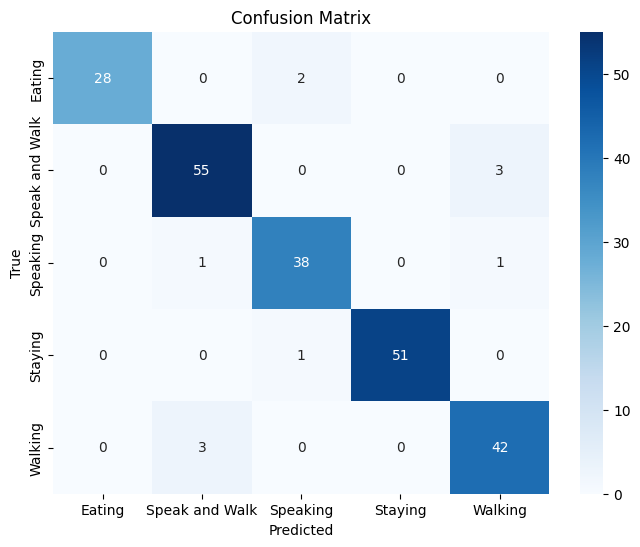

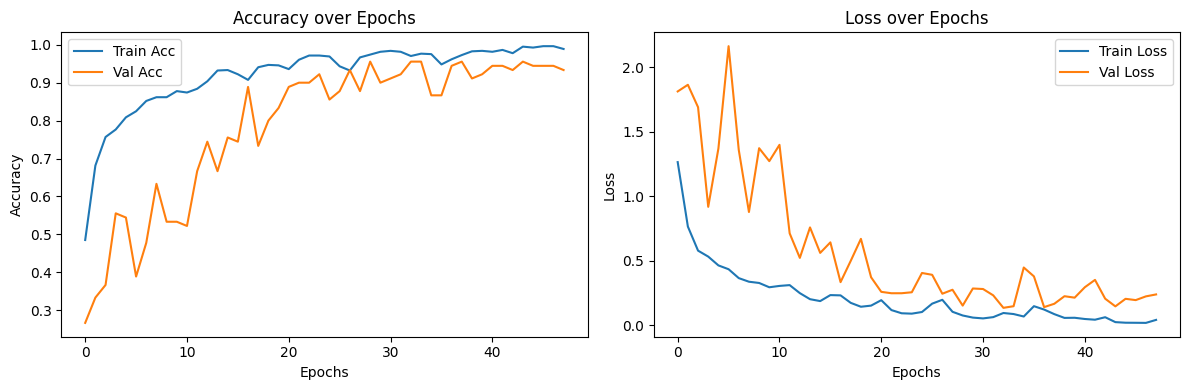

In [7]:
# Colorful confusion matrix
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate
y_pred_dl_probs = model.predict(X_test)
y_pred_dl = np.argmax(y_pred_dl_probs, axis=1)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.tight_layout()
plt.show()


In [8]:
import time
import os

# === 1. Inference time for the full test set ===
start_time = time.time()
_ = model.predict(X_test, verbose=0)
end_time = time.time()

total_samples = len(X_test)
total_time = end_time - start_time
inference_time_per_sample = total_time / total_samples

print(f"\n✅ Total inference time: {total_time:.4f} seconds")
print(f"✅ Average inference time per sample: {inference_time_per_sample * 1000:.4f} ms")

# === 2. Model size ===
model.save("har_model.h5", include_optimizer=False)
model_size_bytes = os.path.getsize("har_model.h5")
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"✅ Model size: {model_size_mb:.2f} MB")



✅ Total inference time: 0.7024 seconds
✅ Average inference time per sample: 3.1218 ms
✅ Model size: 1.11 MB


In [5]:
pip install matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128)  │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 128, 128)  │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 256)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 128)  │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128, 128)  │     16,512 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 128, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 256)  │          0 │ dense_4[0][0]   

 Total params: 927,109 (3.54 MB)

 Trainable params: 927,109 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2366 - loss: 1.6649 - val_accuracy: 0.3556 - val_loss: 1.5319 - learning_rate: 1.0000e-04
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2650 - loss: 1.5436 - val_accuracy: 0.3000 - val_loss: 1.4957 - learning_rate: 1.0000e-04
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 967ms/step - accuracy: 0.2915 - loss: 1.5227 - val_accuracy: 0.3889 - val_loss: 1.4062 - learning_rate: 1.0000e-04
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3885 - loss: 1.4474 - val_accuracy: 0.3833 - val_loss: 1.3839 - learning_rate: 1.0000e-04
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3244 - loss: 1.4360 - val_accuracy: 0.3889 - val_loss: 1.3210 - learning_rate: 1.0000e-04
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3934 - loss: 1.3466 - val_accuracy: 0.4556 - val_loss: 1.2878 - learning_rate: 1.0000e-04
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.37

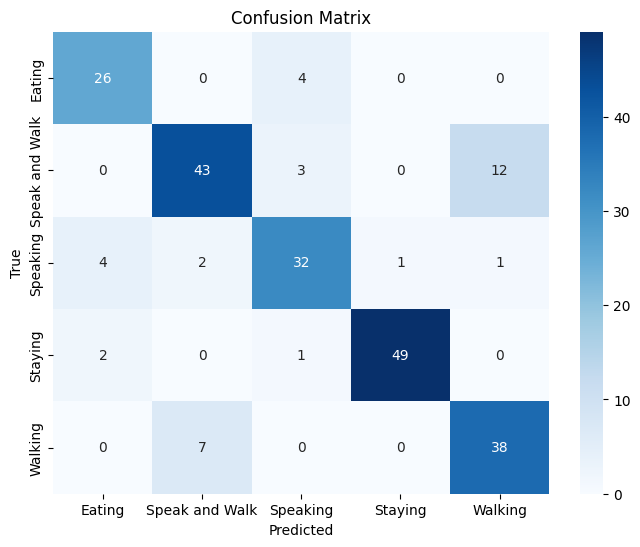

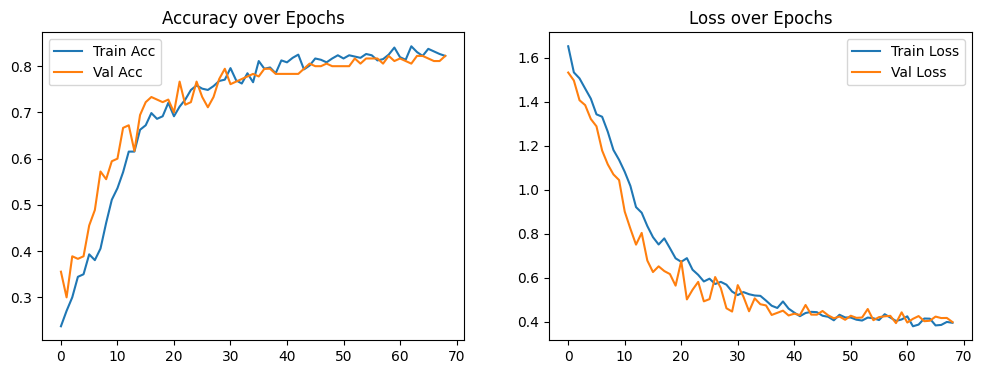

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Load & Normalize ------------------
df = pd.read_csv("AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# ---------------- Sliding Window ------------------
window_size = 128
stride = window_size // 2  # 64
X, y = [], []
values = df[sensor_cols].values
labels = df['Class'].values
for start in range(0, len(values) - window_size + 1, stride):
    end = start + window_size
    X.append(values[start:end])
    y.append(np.bincount(labels[start:end]).argmax())
X = np.array(X)
y = np.array(y)

# ---------------- Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

class_weights = dict(enumerate(
    compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
))

# ---------------- Positional Encoding ------------------
class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ---------------- Temporal Attention Block ------------------
def attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2):
    # Multi-head attention with residual and norm
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(x, x)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network (more dense layers)
    ffn = layers.Dense(ff_dim * 2, activation='gelu')(x)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(ff_dim, activation='gelu')(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    ffn = layers.Dense(x.shape[-1])(ffn)
    
    # Residual and layer norm
    x = layers.Add()([x, ffn])
    return layers.LayerNormalization(epsilon=1e-6)(x)

# ---------------- Deeper Transformer Model ------------------
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial linear projection
    x = layers.Dense(128, activation='relu')(inputs)
    
    # Positional encoding
    x = PositionalEncoding(input_shape[0], 128)(x)

    # Stack multiple attention blocks
    for _ in range(4):  # deeper stack
        x = attention_block(x, num_heads=4, ff_dim=128, dropout_rate=0.2)

    # Global pooling and classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


model = build_model((window_size, 6), num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ---------------- Training ------------------
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train_cat,
                    validation_split=0.2,
                    epochs=150,
                    batch_size=64,
                    callbacks=[early_stop, lr_reduce],
                    class_weight=class_weights,
                    verbose=1)

# ---------------- Evaluation ------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))

# ---------------- Confusion Matrix ------------------
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ---------------- Training Plot ------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()
